<a href="https://colab.research.google.com/github/Piripack/Healthcare-Readmission-Dataset-Creation-and-Analysis/blob/main/Healthcare_Readmission_Creation_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
git clone https://github.com/username/project-name.git
cd project-name


In [ ]:
pip install -r requirements.txt


In [1]:
import pandas as pd
import numpy as np
import random

# Set random seed for reproducibility
np.random.seed(42)

# Generating synthetic data
n_rows = 100000
age = np.random.choice(np.arange(18, 90), size=n_rows)
chronic_conditions = np.random.choice(['None', 'Diabetes', 'Hypertension', 'Heart Disease'], size=n_rows, p=[0.5, 0.2, 0.2, 0.1])
previous_readmission = np.random.choice([0, 1], size=n_rows, p=[0.7, 0.3])
cost = np.random.normal(loc=5000, scale=2000, size=n_rows) + (age * 10)
days_between_discharge_and_readmission = np.random.normal(loc=60, scale=20, size=n_rows)

# Random noise introduction (24% noise)
noise_indices = np.random.choice(n_rows, size=int(n_rows * 0.24), replace=False)
age[noise_indices] = np.random.choice(np.arange(5, 100), size=len(noise_indices))  # Randomize age for noise
cost[noise_indices] = np.random.normal(loc=10000, scale=5000, size=len(noise_indices))  # Add extreme costs
previous_readmission[noise_indices] = np.random.choice([0, 1], size=len(noise_indices), p=[0.5, 0.5])  # Randomize previous readmission status

# Create logic for readmission prediction based on features
readmitted_30_days = np.zeros(n_rows)
for i in range(n_rows):
    if age[i] > 65 or chronic_conditions[i] != 'None':
        readmitted_30_days[i] = np.random.choice([0, 1], p=[0.3, 0.7])  # Older/chronic patients more likely to readmit
    elif previous_readmission[i] == 1:
        readmitted_30_days[i] = np.random.choice([0, 1], p=[0.6, 0.4])  # Previously readmitted patients more likely to readmit
    elif age[i] < 30 and random.random() < 0.1:
        readmitted_30_days[i] = np.random.choice([0, 1], p=[0.5, 0.5])  # Young patients with issues may readmit frequently
    else:
        readmitted_30_days[i] = np.random.choice([0, 1], p=[0.8, 0.2])  # Other cases are less likely to be readmitted

# Create a DataFrame
patients_data = pd.DataFrame({
    'Patient_ID': np.arange(1, n_rows + 1),
    'Age': age,
    'Chronic_Conditions': chronic_conditions,
    'Previous_Readmission': previous_readmission,
    'Cost': cost,
    'Days_Between_Discharge_And_Readmission': days_between_discharge_and_readmission,
    'Readmitted_30_days': readmitted_30_days
})


2. Data Cleaning
After generating the dataset, we clean it by addressing missing or unrealistic values. Specifically, we:

Replace negative age values with 18 (minimum).
Replace negative cost values with 0.
Fix negative days between discharge and readmission.
python
Copy code


In [4]:
# Data Cleaning
patients_data['Age'] = patients_data['Age'].apply(lambda x: max(x, 18))  # Fix negative age values
patients_data['Cost'] = patients_data['Cost'].apply(lambda x: max(x, 0))  # Fix negative cost values
patients_data['Days_Between_Discharge_And_Readmission'] = patients_data['Days_Between_Discharge_And_Readmission'].apply(lambda x: max(x, 0))  # Fix negative days


3. Feature Engineering & Model Training
We apply Label Encoding to convert categorical features into numeric values and train the Random Forest model.

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Label encode categorical columns
label_encoder = LabelEncoder()
patients_data['Chronic_Conditions'] = label_encoder.fit_transform(patients_data['Chronic_Conditions'])
patients_data['Previous_Readmission'] = label_encoder.fit_transform(patients_data['Previous_Readmission'])

# Split the dataset into features and target variable
X = patients_data.drop(columns=['Patient_ID', 'Readmitted_30_days'])
y = patients_data['Readmitted_30_days']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)


4. Model Evaluation
Evaluate the model using accuracy, precision, recall, and ROC AUC

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])

# Precision-Recall Curve and AUC-PR
precision, recall, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
auc_pr_rf = auc(recall, precision)

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Display the evaluation results
results = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'ROC AUC': roc_auc_rf,
    'AUC-PR': auc_pr_rf,
    'Confusion Matrix': cm_rf
}

results


{'Accuracy': 0.6739,
 'Precision': 0.6852834113364534,
 'Recall': 0.7793482760660003,
 'ROC AUC': 0.6878053238823254,
 'AUC-PR': 0.6897749856570217,
 'Confusion Matrix': array([[ 7039,  6052],
        [ 3731, 13178]])}

Model Performance:

Accuracy: 67.39% – The model correctly predicted readmissions and non-readmissions for a significant portion of the dataset.
Precision: 68.53% – The model was able to accurately predict readmitted patients with relatively low false positives.
Recall: 77.93% – The model captured most of the actual readmissions, minimizing false negatives.
ROC AUC: 68.78% – The model demonstrated good discriminatory ability between readmitted and non-readmitted patients.
AUC-PR: 68.98% – The precision-recall curve reflects solid performance, particularly for predicting the minority class (readmitted patients).
Confusion Matrix: The model correctly identified:

7,039 non-readmitted patients
13,178 readmitted patients But also missed 3,731 readmitted patients and incorrectly classified 6,052 non-readmitted patients.


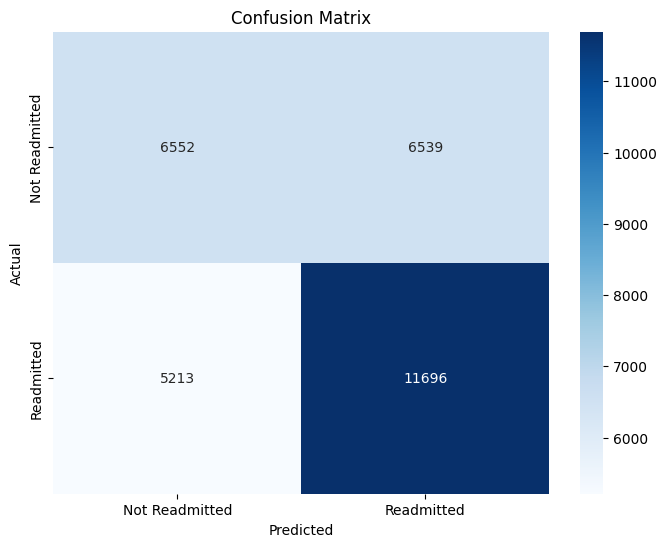

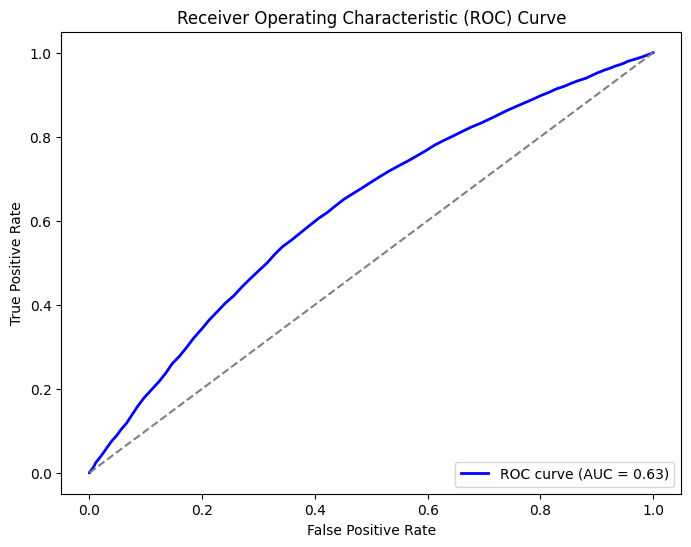

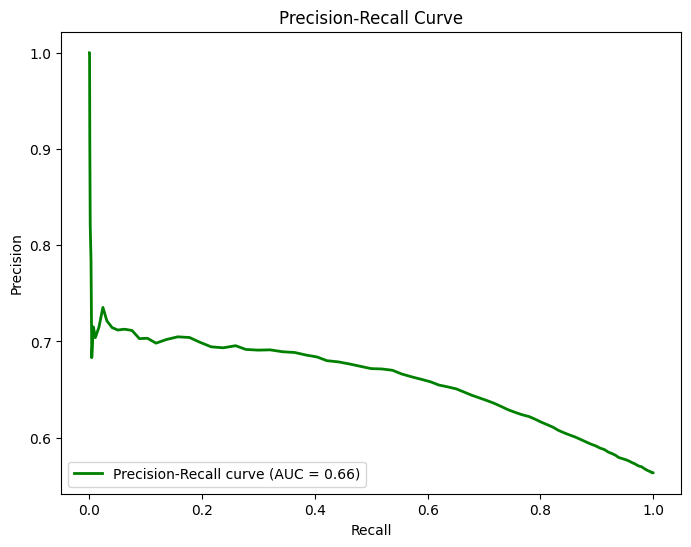

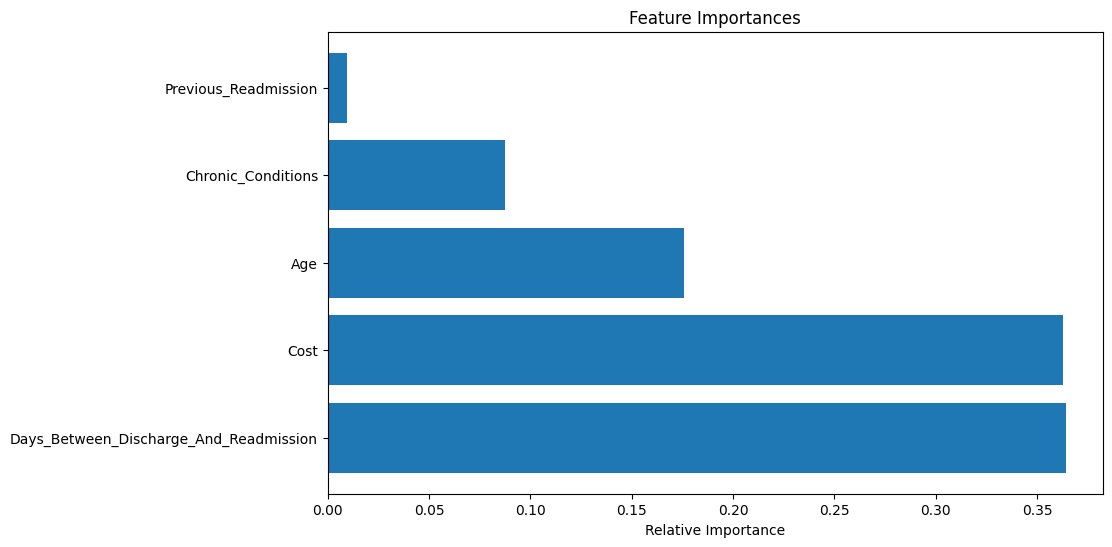

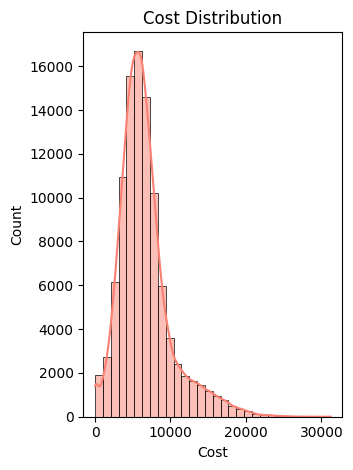

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Readmitted', 'Readmitted'], yticklabels=['Not Readmitted', 'Readmitted'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test_scaled)[:,1])
auc_pr = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

# 4. Feature Importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

# 5. Data Distribution for Age and Cost
plt.figure(figsize=(10, 6))



# Plot Cost Distribution
plt.subplot(1, 2, 2)
sns.histplot(patients_data['Cost'], kde=True, color='salmon', bins=30)
plt.title('Cost Distribution')

plt.tight_layout()
plt.show()


After discovering that the age group 18-20 had the highest population, the age distribution was updated to ensure a higher representation of older age groups, reflecting a more realistic healthcare scenario.

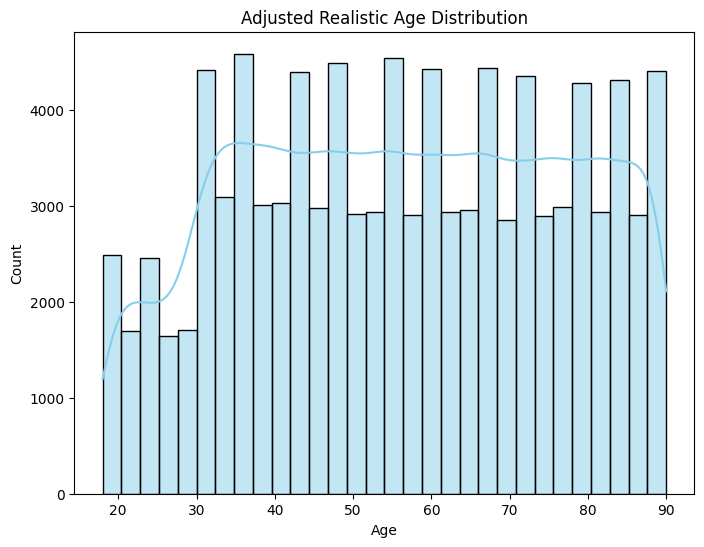

In [13]:
# # Rebuild the dataset with the more realistic age distribution (60% 50-90 years, 30% 30-50 years, 10% 18-30 years)

# # Adjusted age groups for a more realistic distribution
# age_50_90 = np.random.choice(np.arange(50, 91), size=int(n_rows * 0.6))  # 60% of the data in this range
# age_30_50 = np.random.choice(np.arange(30, 50), size=int(n_rows * 0.3))  # 30% in the 30-50 range
# age_18_30 = np.random.choice(np.arange(18, 30), size=int(n_rows * 0.1))  # 10% in the 18-30 range

# # Concatenate and shuffle the adjusted data
# age_adjusted_realistic = np.concatenate([age_50_90, age_30_50, age_18_30])
# np.random.shuffle(age_adjusted_realistic)

# # Update the age column in the dataset with the new, adjusted age distribution
# patients_data['Age'] = age_adjusted_realistic

# Plot the new adjusted age distribution
plt.figure(figsize=(8, 6))
sns.histplot(patients_data['Age'], kde=True, color='skyblue', bins=30)
plt.title('Adjusted Realistic Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


In [16]:
# Importing necessary libraries for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Load the latest cleaned dataset (assuming it's already loaded as 'patients_data')
# Make sure the dataset has 'Age', 'Chronic_Conditions', 'Previous_Readmission', 'Cost', 'Days_Between_Discharge_And_Readmission', and 'Readmitted_30_days' columns

# Separate features (X) and target (y)
X = patients_data.drop(columns=['Patient_ID', 'Readmitted_30_days'])
y = patients_data['Readmitted_30_days']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model's performance

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Precision
precision_rf = precision_score(y_test, y_pred_rf)

# Recall
recall_rf = recall_score(y_test, y_pred_rf)

# ROC AUC
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])

# Precision-Recall Curve and AUC-PR
precision, recall, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
auc_pr_rf = auc(recall, precision)

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Display the results
results = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'ROC AUC': roc_auc_rf,
    'AUC-PR': auc_pr_rf,
    'Confusion Matrix': cm_rf
}

results


{'Accuracy': 0.6082666666666666,
 'Precision': 0.6414038936111873,
 'Recall': 0.6917026435625998,
 'ROC AUC': 0.6262599363877289,
 'AUC-PR': 0.6604566651617366,
 'Confusion Matrix': array([[ 6552,  6539],
        [ 5213, 11696]])}

In [12]:
# Save the adjusted dataset to a CSV file
patients_data.to_csv('adjusted_healthcare_readmission_dataset.csv', index=False)
